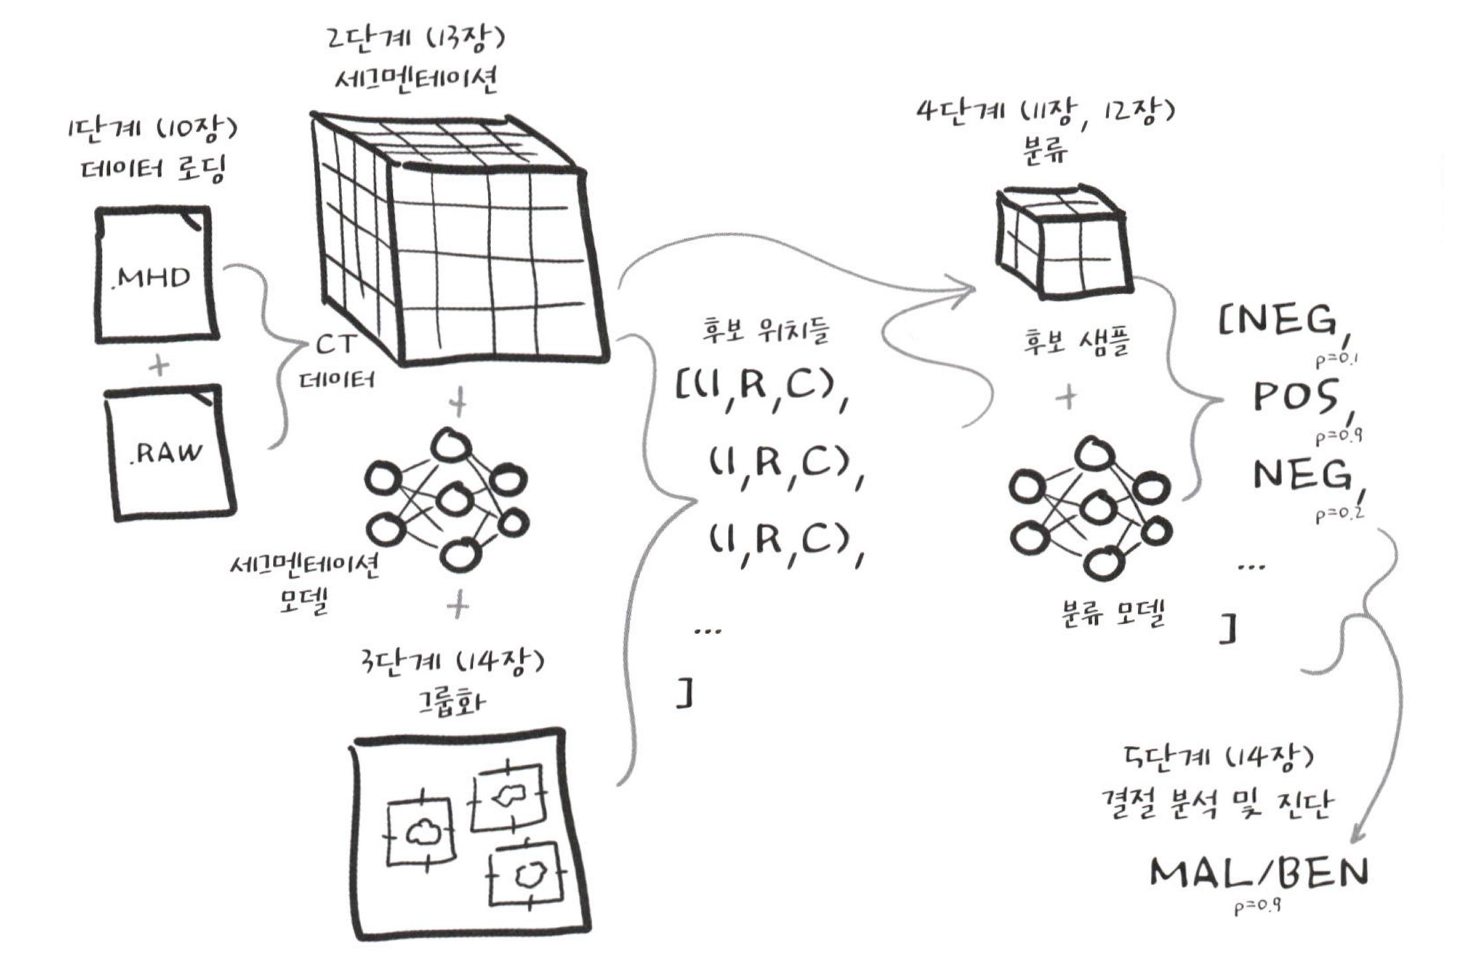

# 13장 세그멘테이션을 활용한 의심 결절 탐색
- 유넷(U-Net) 세그멘테이션
- 다이스 손실(dice loss) 적용
- 세그멘테이션 모델 성능 평가

## 13.1 프로젝트에 두 번째 모델 추가하기
- 지금의 분류기가 동작하기 위해서는 사람이 직접 작업한 결절 후보 정보가 필요
- 분류기는 결절 후보가 중앙에 위치한다고 판단하므로 일정한 위치를 잡지 않으면 정확한 분석이 불가능
- 세그멘테이션을 통해 결절 후보로 표시된 복셀만을 최종 분류 모델에 입력
- 이전에 사용했던 코드들을 조금씩 수정하며 업데이트
    - 모델 업데이트
    - 데이터셋 로딩 프로세스 수정
    - 훈련 프로세스 수정

### 세그멘테이션(segmentation)
- 분류기가 어디를 보아야 할지 알려주는 작업
- 원본 CT 스캔에서 결절일 가능성이 있는 지점을 찾아 해당 복셀을 표시
- 새로운 입력과 출력에 맞추기 위해 모델, 데이터셋, 훈련 루프를 업데이트
- 새롭게 얻어진 세그멘테이션 모델을 실행하고 결과를 평가

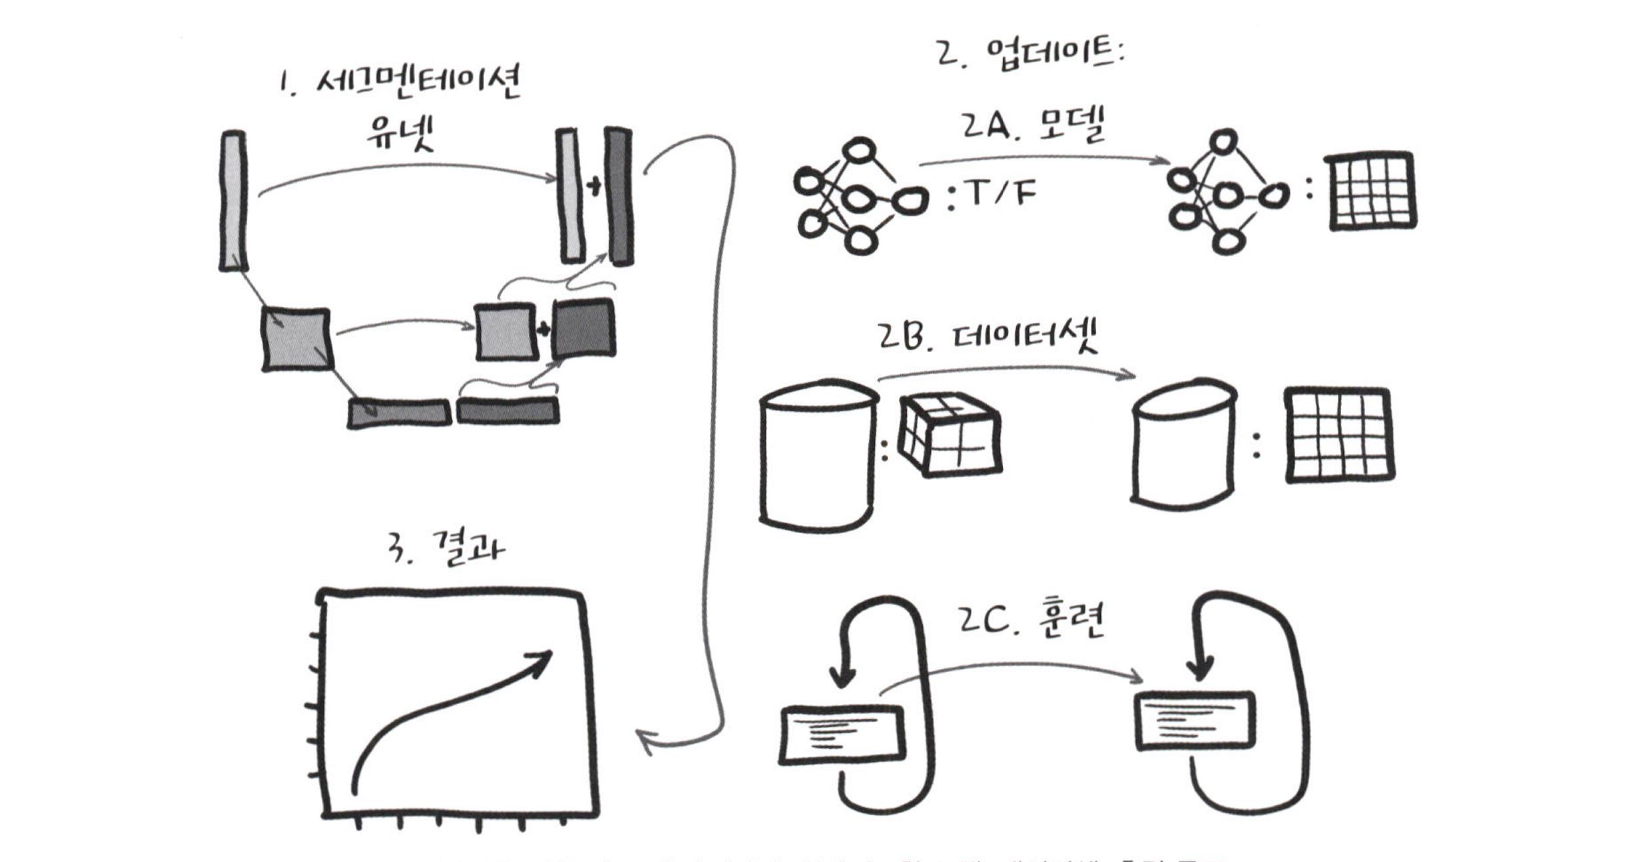

1. 세그멘테이션
    - 유넷 모델 세그멘테이션 과정에 대한 이해
2. 업데이트
    - 모델 업데이트(2A)
        - 기존의 유넷 모델을 가져와서 프로젝트에 맞게 적용
        - 이전 장의 모델이 T/F 분류를 출력했다면 이번 모델은 이미지 전체를 출력
    - 데이터셋 변경(2B)
        - CT 데이터(밀도 픽셀) 뿐만 아니라 결절 마스크 정보도 제공하도록 데이터셋 수정
        - 세그멘테이션 훈련과 검증을 위한 CT 단면 전체와 2차원 크롭이 필요
        - 분류 데이터셋은 결절 후보를 3차원으로 잘라낸 것으로 구성했다면, 이번에는 2차원 데이터로 표현
    - 훈련 루프 수정(2C)
        - 훈련 루프에 새로운 종류의 손실값과 옵티마이저를 도입
        - 텐서보드에서 세그멘테이션 결과를 이미지로 확인
3. 결과
    - 정량적인 세그멘테이션 결과 확인

## 13.2 다양한 세그멘테이션 유형
- 의미론적 세그멘테이션 (** 프로젝트에 사용되는 방식)
- 인스턴스 세그멘테이션
- 객체 탐지

### 의미론적(semantic) 세그멘테이션
- 곰, 개, 고양이 등의 레이블을 사용해 이미지의 개별 픽셀을 분류하는 방식
- 각 픽셀들이 어떤 레이블에 해당하는지 영역을 구분해주고 관심 영역을 레이블 마스크나 히트맵 형식으로 출력
- 프로젝트에서는 이진 레이블 세그멘테이션을 통해 분류 신경망에 입력할 결절 후보를 결정
    - 결절이 의심되는 후보 조직(T)
    - 결절과 무관한 건강 조직(F)

### 인스턴스(instance) 세그멘테이션
- 여러 구분된 레이블을 사용하여 관심 객체를 개별적으로 레이블링
- ex) 두 사람이 악수하는 그림에 대한 레이블
    - 의미론적: '사람', '배경'
    - 인스턴스: '사람1', '사람2', '배경' (악수하는 손 근처에 경계선)
- 프로젝트에서 '결절1', '결절2'로 구분될 만큼 결절이 인접해있는 경우는 매우 드물기 때문에 의미론적 방법을 사용

### 객체 탐지(object detection)
- 이미지에서 관심 있는 아이템 위치 주변에 경계 박스(bounding box)를 그려주는 방식
- 인스턴스 방식과 객체 탐지는 유용하지만 구현이 복잡하고 모델 훈련에 많은 연산이 필요
    - 세밀한 세그멘테이션이 프로젝트의 주된 목적이 아니라면 의미론적 세그멘테이션이 효율적

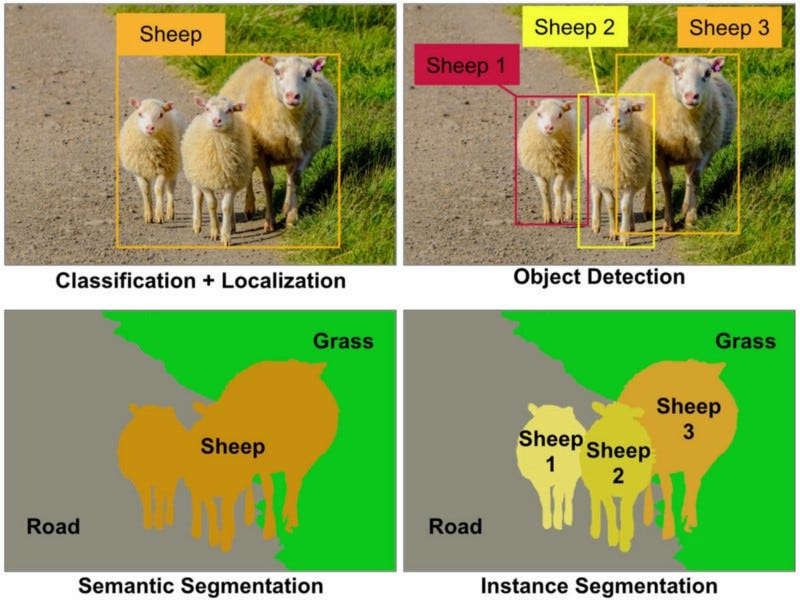

- semantic segmentation + object detection = instance segmentation
- 분류 모델은 사진 속에 사물이 있는지 여부를 판단
- 세그멘테이션 모델을 통해 사물이 사진 속 어느 부분에 있는지 파악

## 13.3 시맨틱 세그멘테이션: 픽셀 단위 분류

### 분류(classification) 모델
- 컨볼루션, 풀링(다운샘플링) 레이어가 반복되며 픽셀 배열을 축소
- 다운샘플링을 통해 픽셀 배열을 축소하여 이미지를 최종적으로 하나의 클래스 리스트로 변환 (flatten)

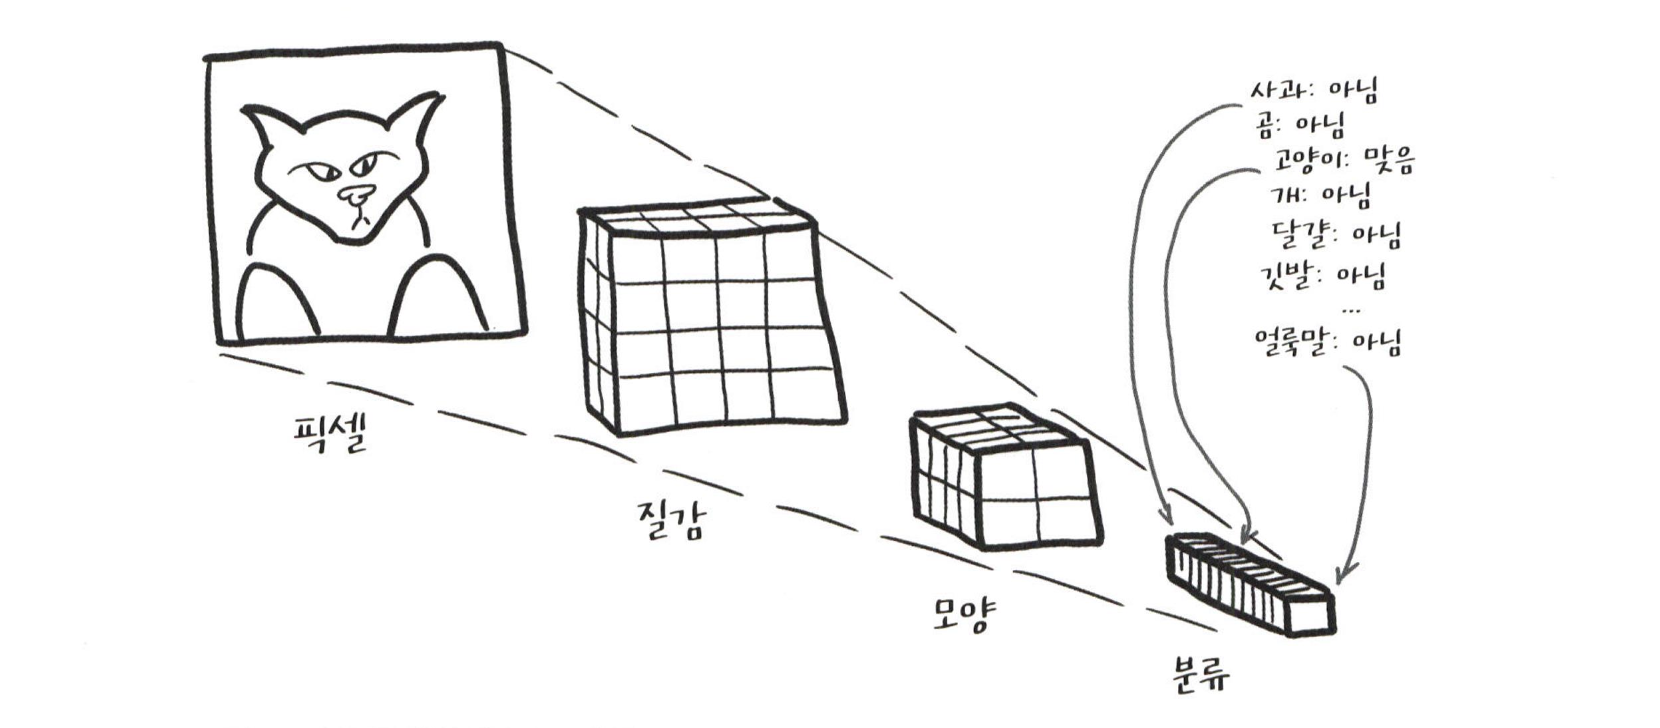

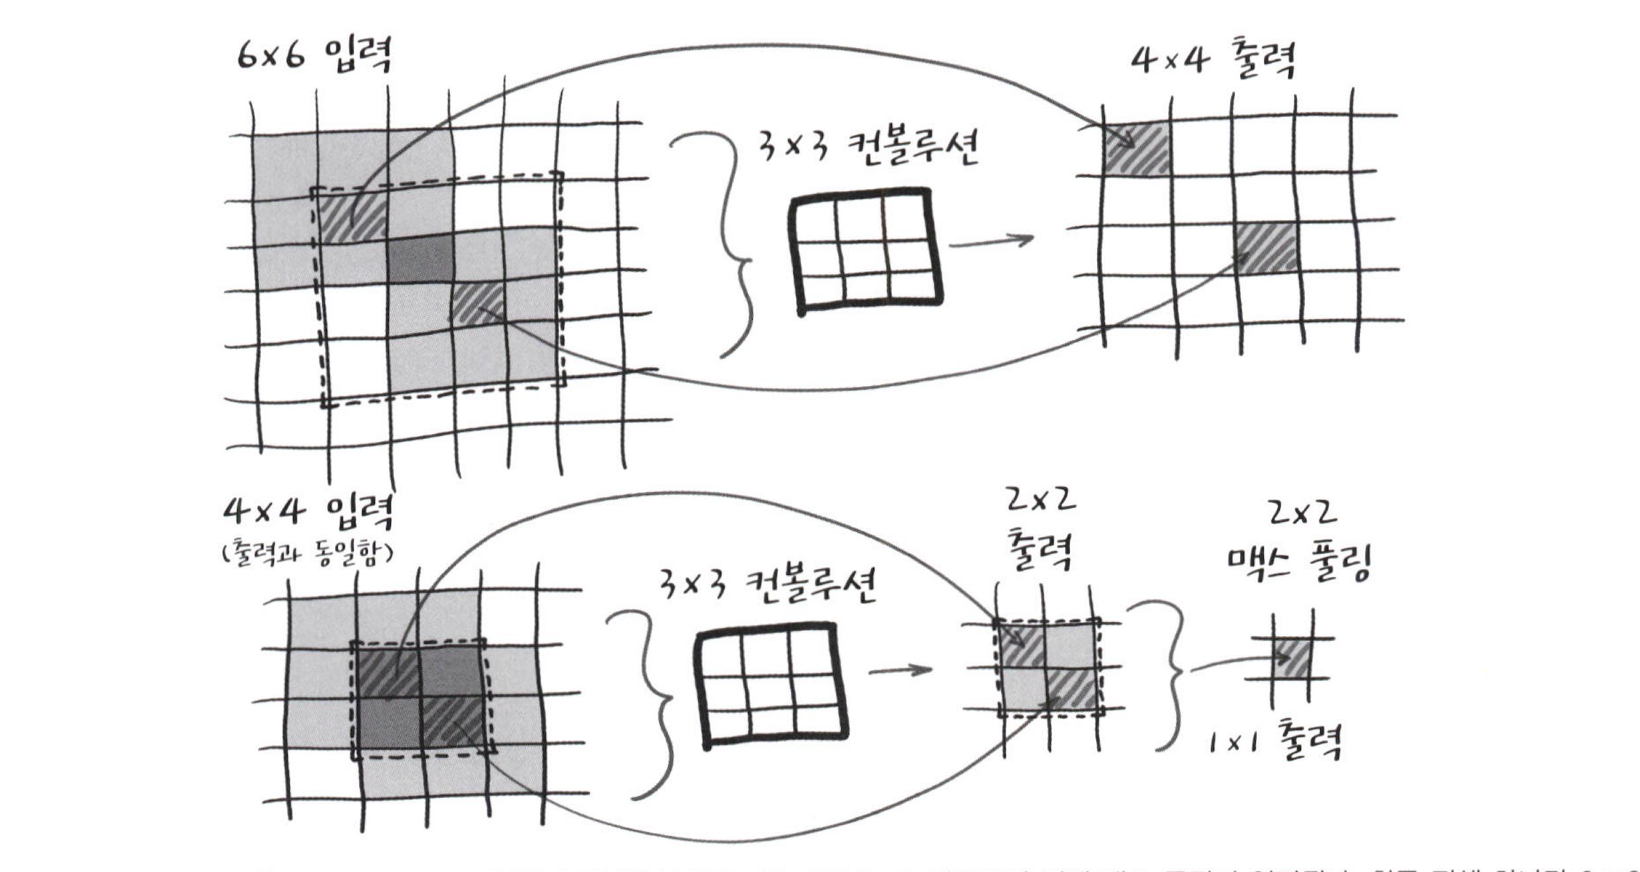

### 유넷(U-Net) 모델
- U-Net: Convolutional Networks for Biomedical Image Segmentation ([link](https://arxiv.org/abs/1505.04597))
    - https://wikidocs.net/148870
    - https://pasus.tistory.com/204
- 2차원 이미지 세그멘테이션 모델

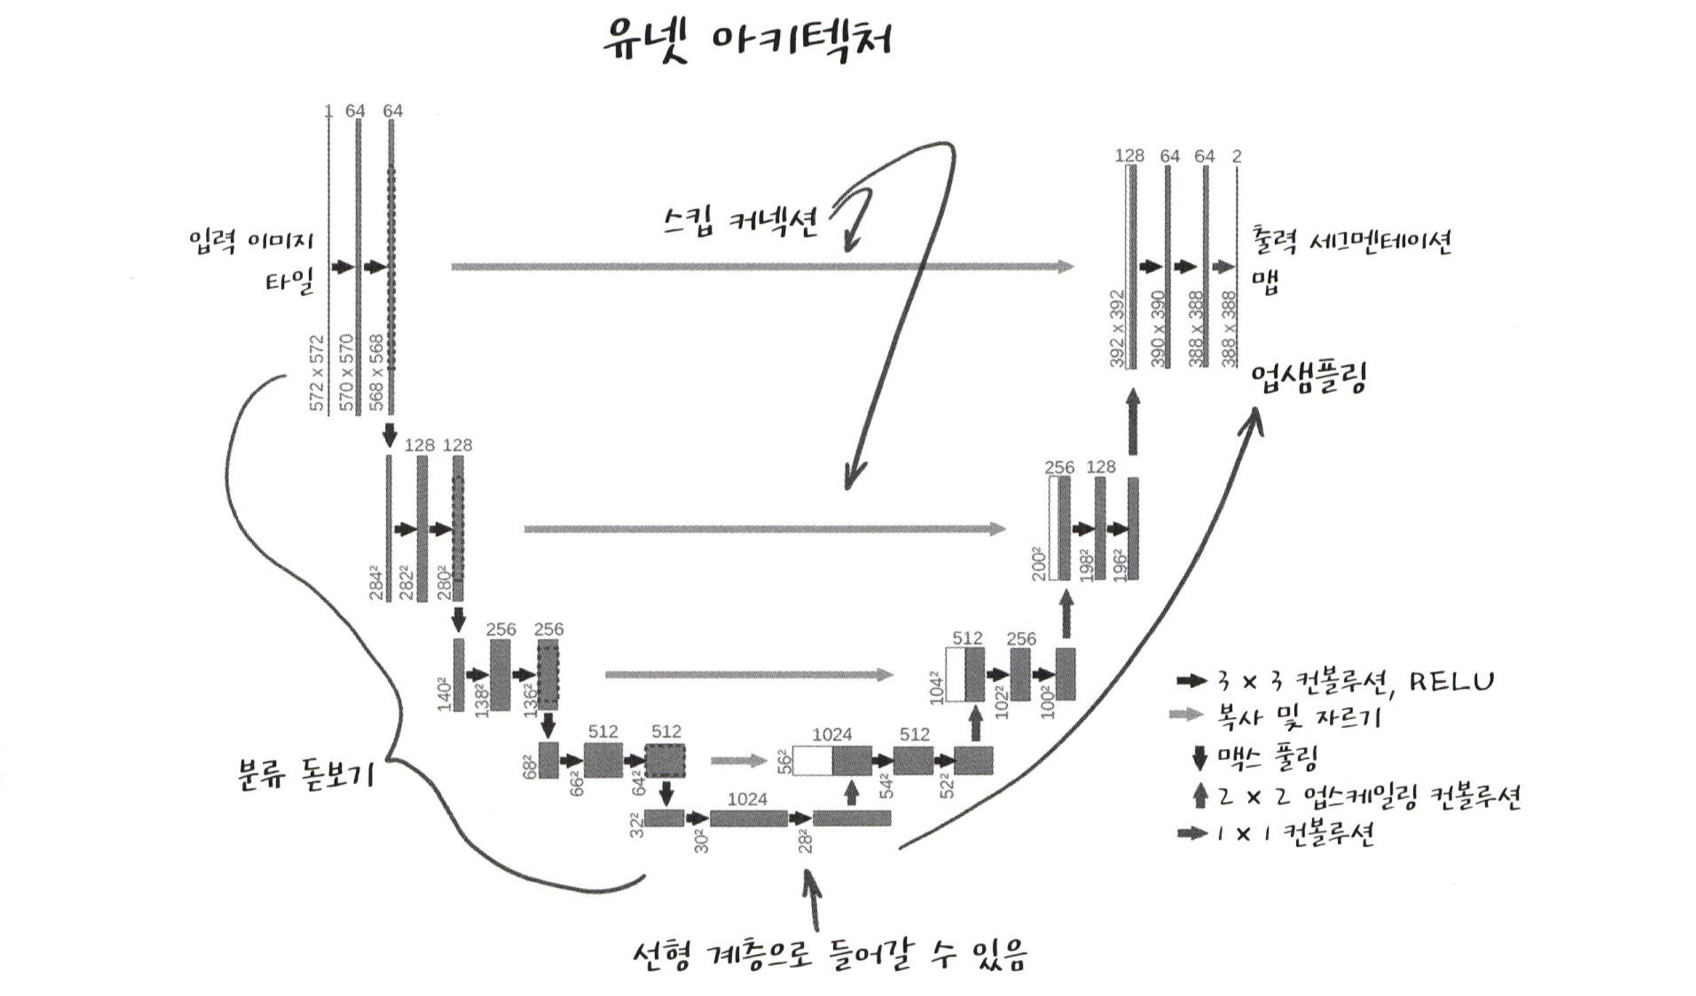

- https://github.com/jvanvugt/pytorch-unet
- 기존의 이진 분류 모델이 세그멘테이션을 수행하여 모든 픽셀에 대해 결절일 확률을 출력하도록 업데이트 (업컨볼루션)
- 위치 정보의 손실을 최소화하기 위해 스킵 커넥션을 적용

## 13.4 세그멘테이션을 위한 모델 업데이트
- 2차원 다채널 데이터를 입력으로 사용
    - 세그멘테이션하고자 하는 단면과 위아래로 인접한 단면들을 채널로 구분
    - 인접한 단면이 있으면 밝은 덩어리를 추적하기 용이

In [ ]:
# model.py

class UNetWrapper(nn.Module):
    def __init__(self, **kwargs): # UNet에 전달할 키워드 인자
        super().__init__()

        self.input_batchnorm = nn.BatchNorm2d(kwargs['in_channels']) # 입력 채널 수 (세그멘테이션 단면과 인접 단면)
        self.unet = UNet(**kwargs) # UNet 모듈
        self.final = nn.Sigmoid() # 출력값의 범위를 [0, 1]로 제한 (확률이므로)

        self._init_weights()

    # 모델 가중치 초기화: https://github.com/pytorch/pytorch/issues/18182
    def _init_weights(self):
        init_set = {
            nn.Conv2d,
            nn.Conv3d,
            nn.ConvTranspose2d,
            nn.ConvTranspose3d,
            nn.Linear,
        }
        for m in self.modules():
            if type(m) in init_set:
                nn.init.kaiming_normal_(
                    m.weight.data, mode='fan_out', nonlinearity='relu', a=0
                )
                if m.bias is not None:
                    fan_in, fan_out = \
                        nn.init._calculate_fan_in_and_fan_out(m.weight.data)
                    bound = 1 / math.sqrt(fan_out)
                    nn.init.normal_(m.bias, -bound, bound)

    def forward(self, input_batch):
        bn_output = self.input_batchnorm(input_batch)
        un_output = self.unet(bn_output)
        fn_output = self.final(un_output) # 해당 픽셀이 결절의 일부인지에 대한 확률

        return fn_output # 단일 채널 출력 (인접 단면을 제외한 단일 단면)

## 13.5 세그멘테이션을 위한 데이터셋 업데이트
- 입출력 크기 통일을 위한 패딩
- 각 단면을 채널로 가지는 2차원 이미지로 표현

### 패딩(padding)
- 유넷 논문에서 572 * 572 이미지 패치를 입력으로 사용했고 출력 맵의 크기는 388 * 388
    - 패딩 없이 컨볼루션 연산을 반복적으로 수행했기 때문에 이미지의 크기 감소
- 입력으로 사용할 단면의 크기는 512 * 512로 논문의 입력 사이즈보다 작아서 CT 스캔 경계 부근이 세그멘테이션되지 않는 문제 발생
- 이를 보완하기 위해 padding=True를 넘겨주어 출력 맵의 크기를 입력 이미지의 크기와 동일하게 설정

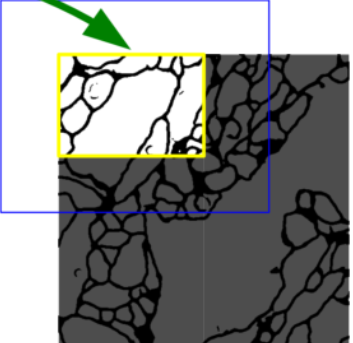

"Prediction of the segmentation in the yellow area requires image data within the blue area as input."<br>
"Missing input data is extrapolated by mirroring."

### Mirroring Extrapolation
- missing data 문제를 해결하기 위해 사용
- 파란색 박스의 빈 공간을 노란색 영역이 거울에 반사된 형태로 채우는 방식
- data augmentation 효과를 줄 수 있어 파란색 박스를 zero 픽셀로 치우는 zero padding보다 나은 방법

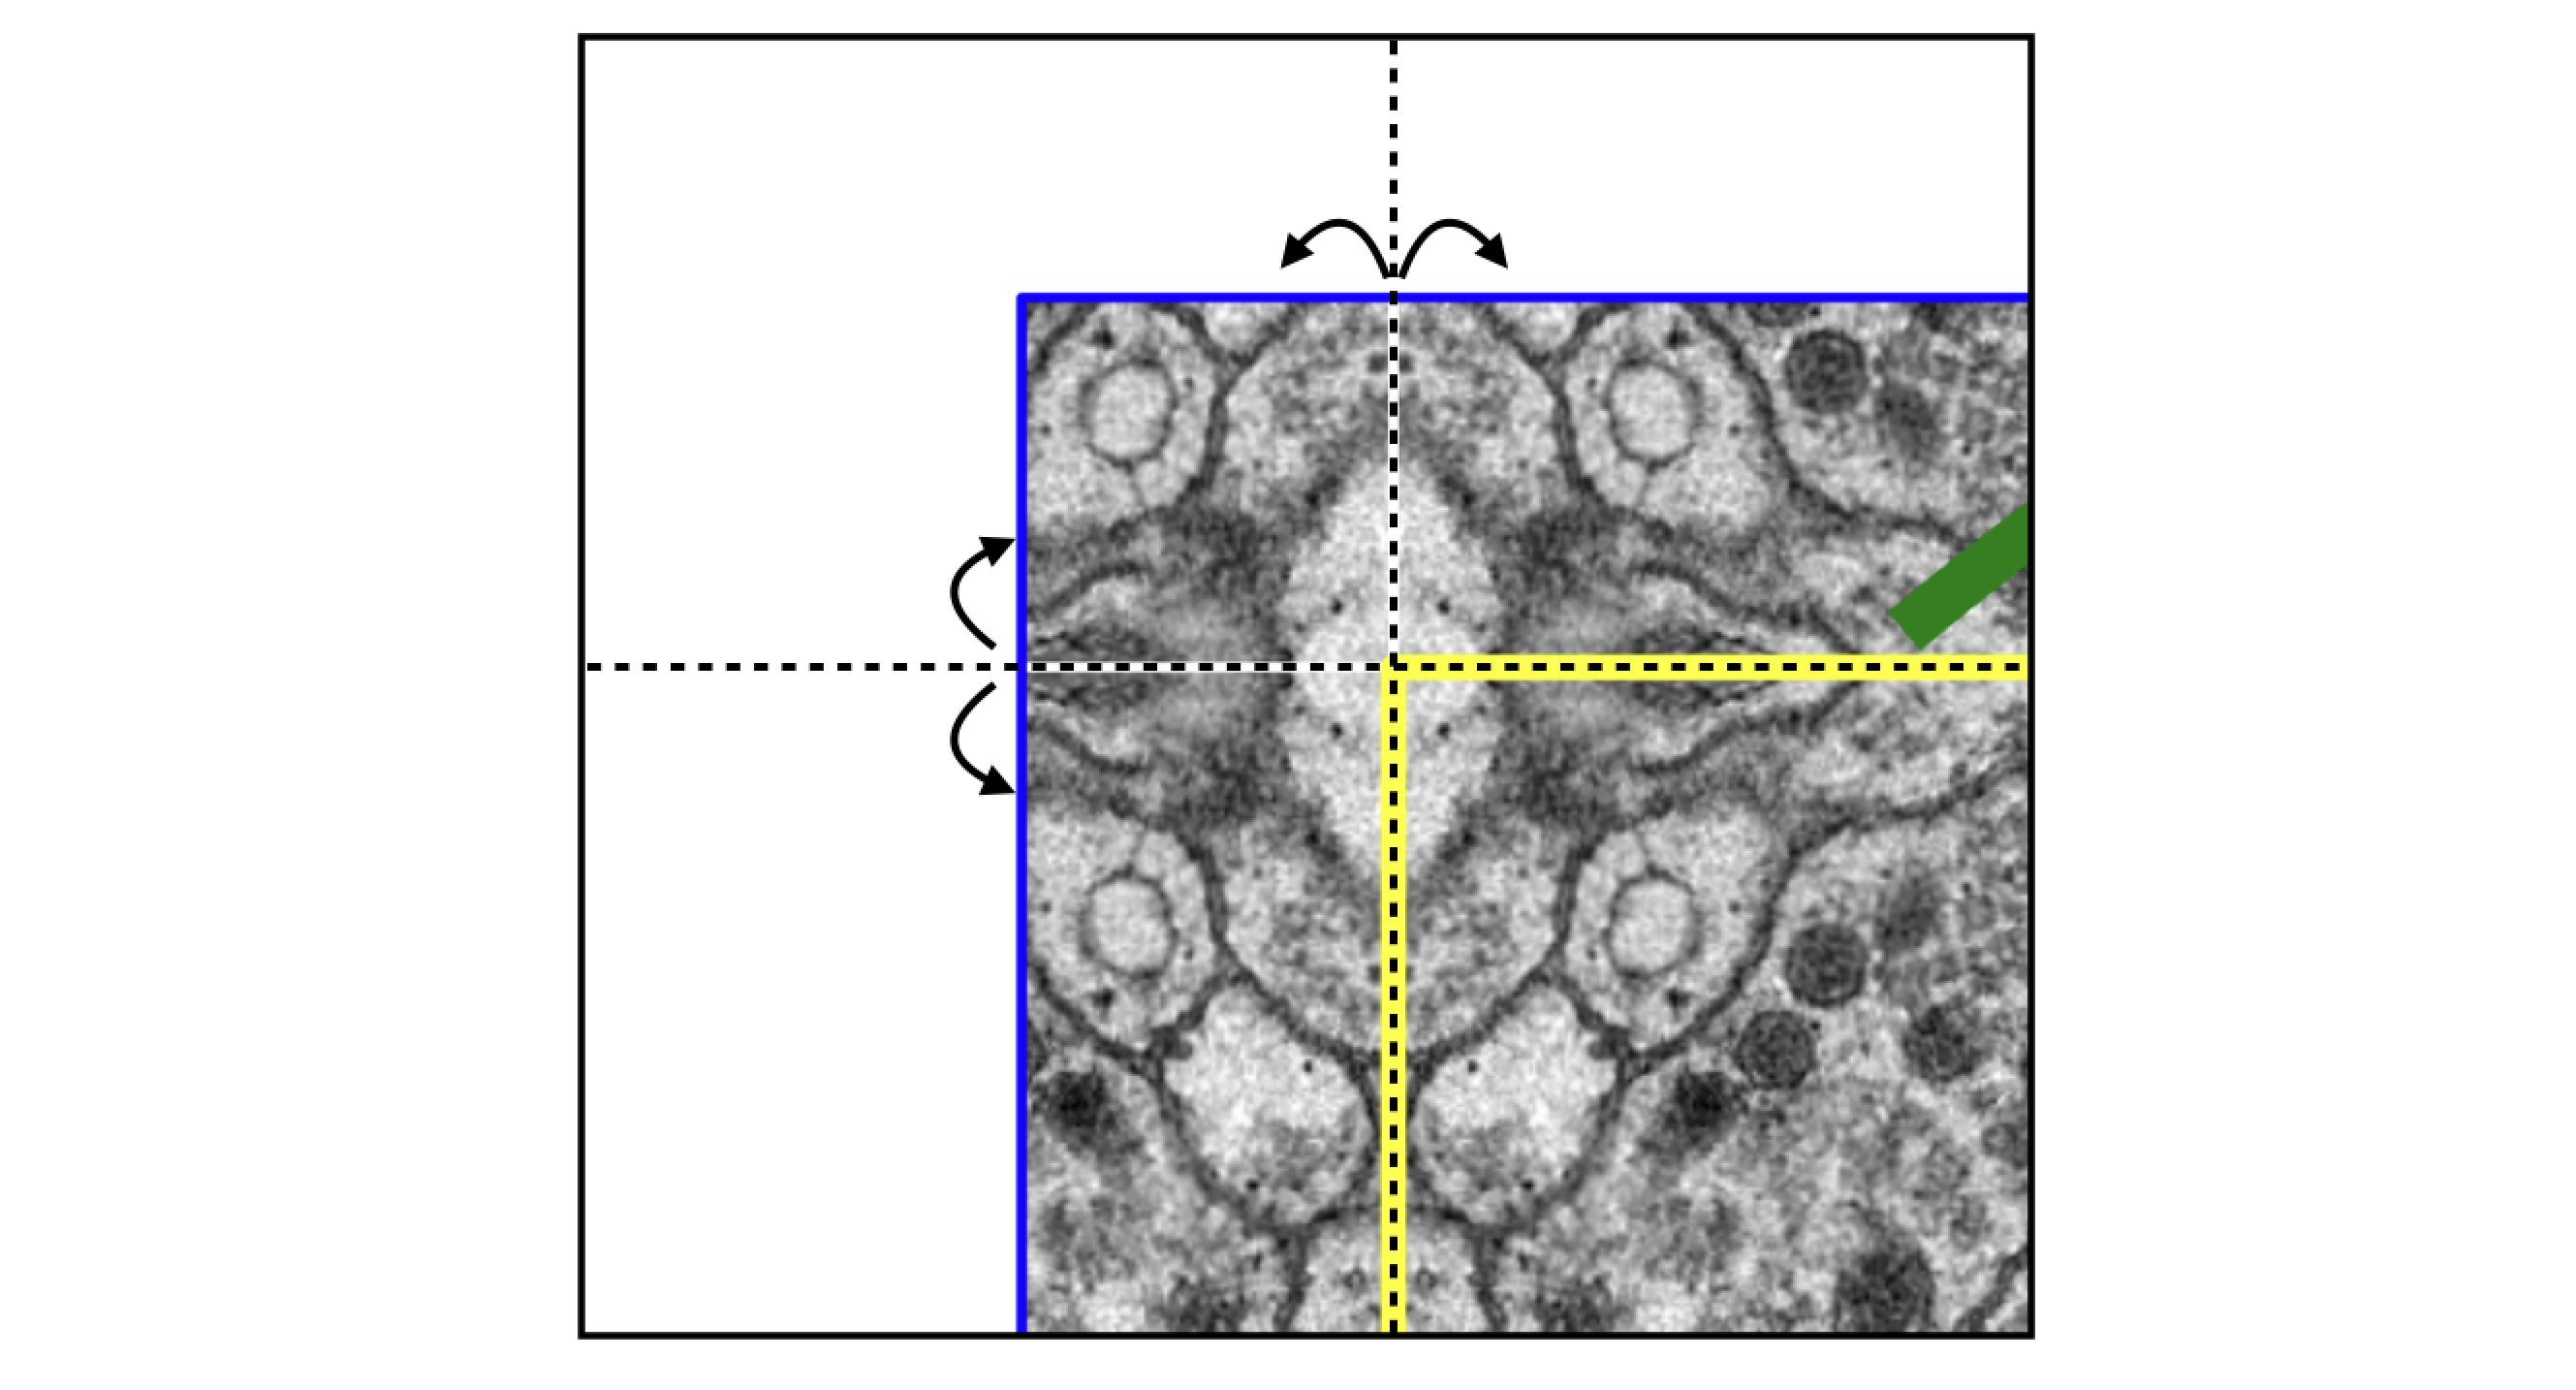

### 2차원 다채널 이미지
- 각 단면에 대한 2차원 세그멘테이션 문제로 정의
- 세그멘테이션하고자 하는 단면에 인접한 단면을 별도 채널로 제공하여 3차원 정보를 고려하는 방식
    - RGB 대신 현재 단면과 위아래로 인접한 단면을 채널로 사용
- 채널로 표현하면 CT 단면 간의 순서 관계에 손실 발생
    - 코드 적용 시 csv 파일의 series_uid 정보를 활용하여 순서 관계를 고려한 입력 데이터를 생성

### 실측 데이터: 바운딩 박스(bounding box)
- 분류 모델에 입력할 데이터를 만들기 위해 주어진 복셀이 결절 영역에 해당하는지를 알려주는 복셀 단위의 마스크 정보가 필요
- 결절의 위치(좌표) 정보를 가지고 결절 전체를 둘러싸는 바운딩 박스를 만드는 작업
    - 이미지 상 결절 모양의 대략적인 중심 부위가 결절의 위치라고 가정
    - 결절의 중심부에서 바깥쪽으로 저밀도 복셀(공기로 차 있는 일반 폐 조직)을 만날 때까지 확장

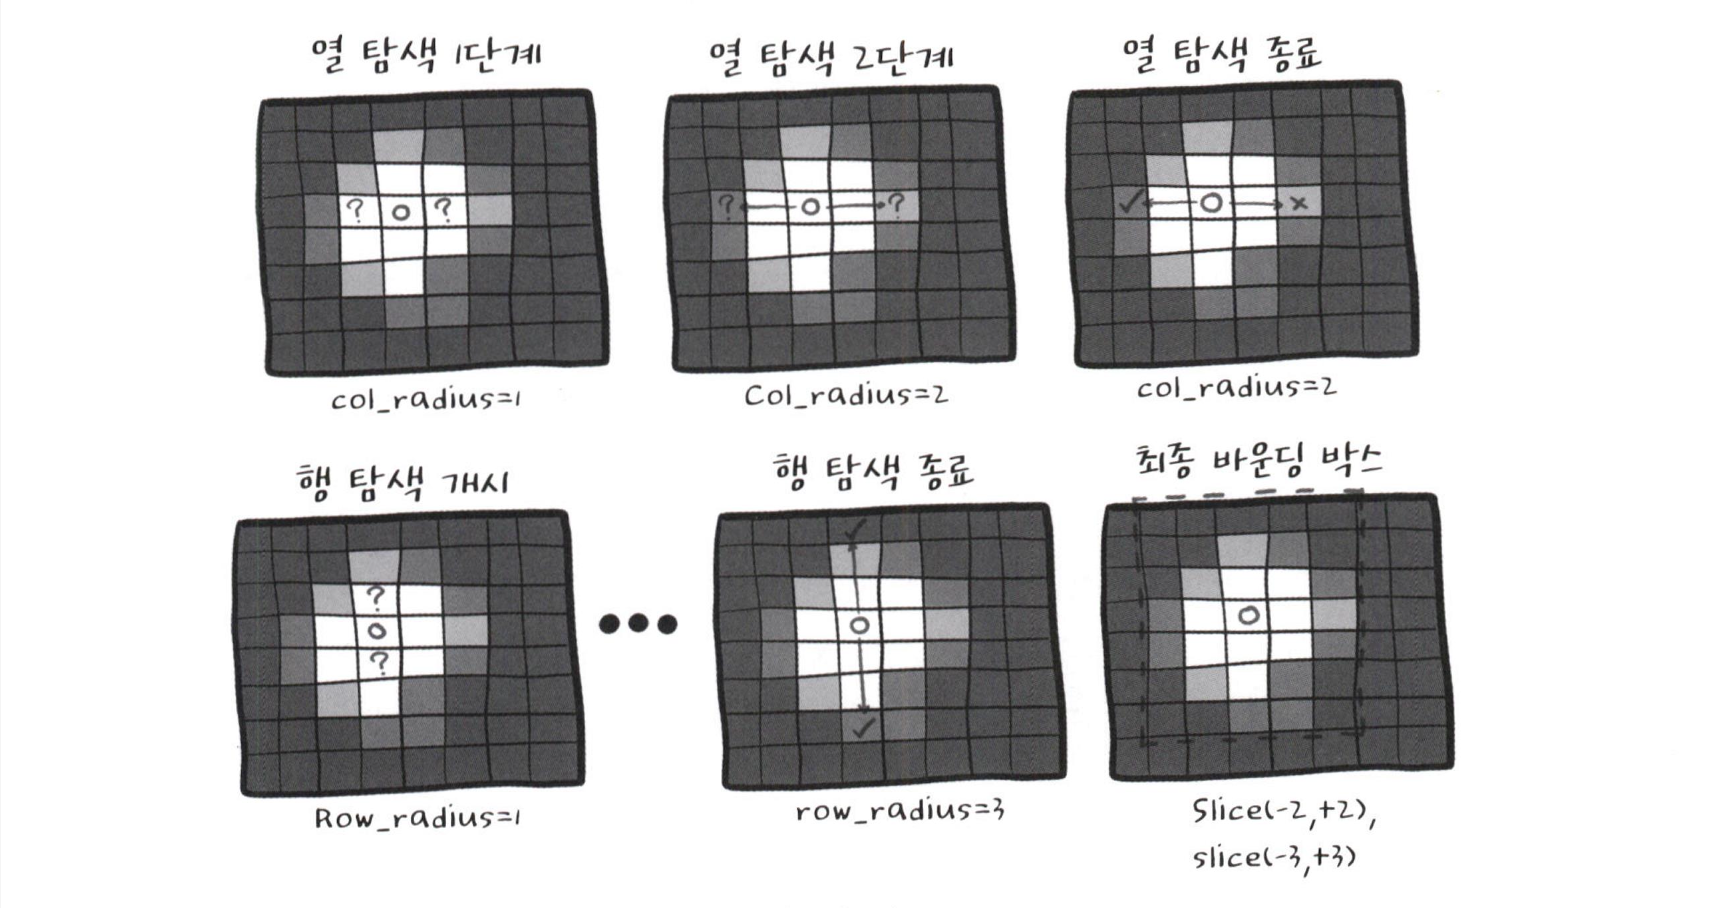

- annotation 파일에서 결절의 중심점 좌표로 표시된 지점을 출발점으로 하여 복셀 탐색을 시작
- 열과 행 각각의 축에 따라 중심점과 인접한 복셀의 밀도를 검사
- 두 복셀이 모두 고밀도 조직(밝게 표시된 부분)을 포함하고 있다면 탐색을 계속 진행
- 둘 중 하나라도 밀도가 임계값보다 낮은 복셀을 포함한다면 탐색을 중지
- 위의 예시에서 최종 바운딩 박스의 사이즈는 5 * 7 (복셀 단위)

### Ct 클래스에 바운딩 박스 생성 함수 추가

In [ ]:
# dsets.py

@functools.lru_cache(1) # 함수의 결과를 캐싱해주는 decorator

def getCandidateInfoDict(requireOnDisk_bool=True): # candidateInfo_list to candidateInfo_dict (동일한 정보 재구성)
    candidateInfo_list = getCandidateInfoList(requireOnDisk_bool)
    candidateInfo_dict = {}

    for candidateInfo_tup in candidateInfo_list:
        candidateInfo_dict.setdefault(candidateInfo_tup.series_uid, []).append(candidateInfo_tup)

    return candidateInfo_dict # series_uid를 key로 가지는 딕셔너리 형태

class Ct:
    def __init__(self, series_uid):
        mhd_path = glob.glob('./data/cancer/luna/subset0/{}.mhd'.format(series_uid))[0]

        ct_mhd = sitk.ReadImage(mhd_path)
        self.hu_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)

        self.series_uid = series_uid

        self.origin_xyz = XyzTuple(*ct_mhd.GetOrigin())
        self.vxSize_xyz = XyzTuple(*ct_mhd.GetSpacing())
        self.direction_a = np.array(ct_mhd.GetDirection()).reshape(3, 3)

        candidateInfo_list = getCandidateInfoDict()[self.series_uid]

        # 실제 결절만 포함하는 리스트 (isNodule_bool == True)
        self.positiveInfo_list = [
            candidate_tup
            for candidate_tup in candidateInfo_list
            if candidate_tup.isNodule_bool
        ]

        # 바운딩 박스(annotation mask) 생성
        self.positive_mask = self.buildAnnotationMask(self.positiveInfo_list)

        # 결절 마스크 복셀이 적어도 하나 이상 포함된 단면의 인덱스 리스트
        self.positive_indexes = (self.positive_mask.sum(axis=(1,2))
                                 .nonzero()[0].tolist()) # 활성화된 복셀 마스크의 개수가 0이 아닌 단면의 인덱스를 리스트로 반환

    def buildAnnotationMask(self, positiveInfo_list, threshold_hu = -700): # hu: hounsfield unit (밀도 단위)
        boundingBox_a = np.zeros_like(self.hu_a, dtype=np.bool) # CT 스캔과 동일한 크기의 False 텐서로 시작

        for candidateInfo_tup in positiveInfo_list:

            # xyz 좌표를 배열 좌표(irc)로 변환
            center_irc = xyz2irc(
                candidateInfo_tup.center_xyz,
                self.origin_xyz,
                self.vxSize_xyz,
                self.direction_a,
            )

            # 중심점 복셀의 irc에서 출발
            ci = int(center_irc.index)
            cr = int(center_irc.row)
            cc = int(center_irc.col)

            # irc 각각에 대해 동일한 반지름 확장 과정을 반복
            index_radius = 2
            try:
                while self.hu_a[ci + index_radius, cr, cc] > threshold_hu and \
                        self.hu_a[ci - index_radius, cr, cc] > threshold_hu:
                    index_radius += 1
            except IndexError: # 인덱스가 텐서 경계를 넘어서는 경우는 예외 처리 (결절이 단면의 모서리 부분에 존재)
                index_radius -= 1

            row_radius = 2
            try:
                while self.hu_a[ci, cr + row_radius, cc] > threshold_hu and \
                        self.hu_a[ci, cr - row_radius, cc] > threshold_hu:
                    row_radius += 1
            except IndexError:
                row_radius -= 1

            col_radius = 2
            try:
                while self.hu_a[ci, cr, cc + col_radius] > threshold_hu and \
                        self.hu_a[ci, cr, cc - col_radius] > threshold_hu:
                    col_radius += 1
            except IndexError:
                col_radius -= 1

            # 결절 탐색이 끝나면 바운딩 박스 내의 픽셀들을 True 값으로 업데이트
            boundingBox_a[
                 ci - index_radius: ci + index_radius + 1,
                 cr - row_radius: cr + row_radius + 1,
                 cc - col_radius: cc + col_radius + 1] = True

        mask_a = boundingBox_a & (self.hu_a > threshold_hu) # 임계값보다 밀도가 높은 복셀만 마스크에 포함되도록 제한 (양방향 탐색)

        return mask_a

    def getRawCandidate(self, center_xyz, width_irc):
        center_irc = xyz2irc(center_xyz, self.origin_xyz, self.vxSize_xyz,
                             self.direction_a)

        slice_list = []
        for axis, center_val in enumerate(center_irc):
            start_ndx = int(round(center_val - width_irc[axis]/2))
            end_ndx = int(start_ndx + width_irc[axis])

            assert center_val >= 0 and center_val < self.hu_a.shape[axis], \
            repr([self.series_uid, center_xyz, self.origin_xyz, self.vxSize_xyz, center_irc, axis])

            if start_ndx < 0:
                start_ndx = 0
                end_ndx = int(width_irc[axis])

            if end_ndx > self.hu_a.shape[axis]:
                end_ndx = self.hu_a.shape[axis]
                start_ndx = int(self.hu_a.shape[axis] - width_irc[axis])

            slice_list.append(slice(start_ndx, end_ndx))

        ct_chunk = self.hu_a[tuple(slice_list)] # 기존에 사용했던 CT 데이터 캐시
        pos_chunk = self.positive_mask[tuple(slice_list)] # 새로 추가한 positive_mask 캐시

        return ct_chunk, pos_chunk, center_irc # pos_chunk 값을 함께 반환

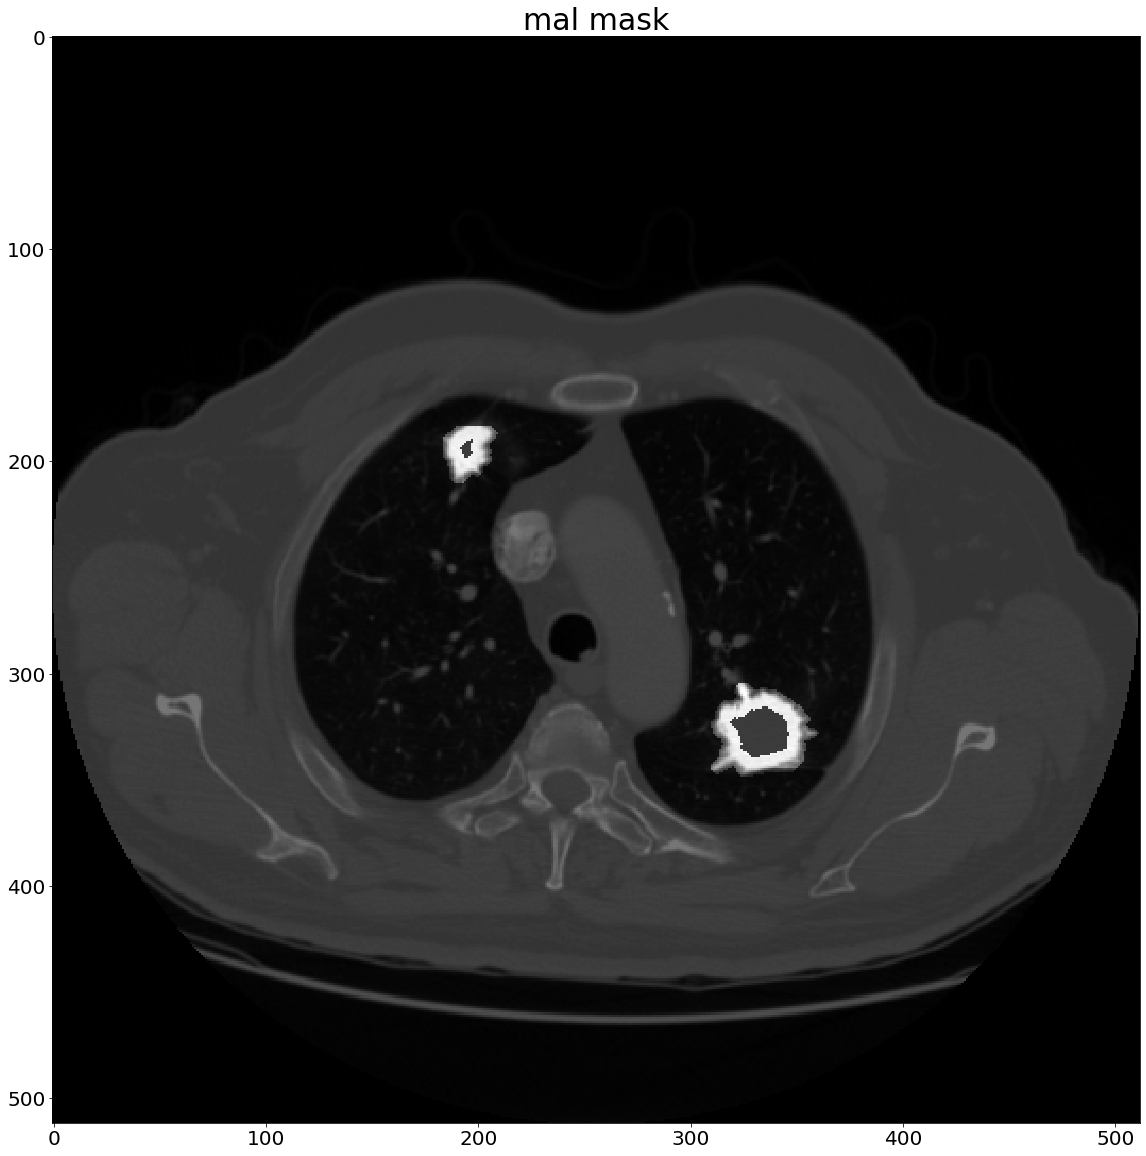

### CT와 함께 마스크도 캐싱하기
- 앞선 단원들에서 이미 결절 후보 주위로 중심이 잡힌 여러 CT를 캐싱하는 작업을 수행
- positive_mask에 대해서도 동일한 캐싱 작업이 필요
    - 캐시를 반환하는 Ct.getRawCandidate 함수에서 양성 마스크도 반환하도록 추가

In [ ]:
# dsets.py

raw_cache = getCache('part2ch13_raw')

@functools.lru_cache(1, typed=True)
def getCt(series_uid):
    return Ct(series_uid)

@raw_cache.memoize(typed=True)
def getCtRawCandidate(series_uid, center_xyz, width_irc):
    ct = getCt(series_uid)
    ct_chunk, pos_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)
    ct_chunk.clip(-1000, 1000, ct_chunk) # 이상치 제거
    return ct_chunk, pos_chunk, center_irc # CT, 양성 마스크, 중심점 캐시 정보

@raw_cache.memoize(typed=True)
def getCtSampleSize(series_uid):
    ct = Ct(series_uid)
    return int(ct.hu_a.shape[0]), ct.positive_indexes # CT 전체 단면 수, 양성 마스크 인덱스 캐시 정보

### annotations 파일 정제하기
- 현재 candidates.csv 파일은 중복된 데이터를 포함
    - 동일한 결절인데 서로 다른 CT 단면에서 각기 annotation이 달린 경우
- 중복 없이 정제된 annotions.csv 파일이 필요

"우리는 이미 발품을 팔아 원본 애노테이션으로부터 결절 정보를 꺼내어 중복이 없도록 추려서 annotations_with_malignancy.csv에 담아놓았다." <br>
"이 파일로 새 애노테이션 파일로부터 결절을 추출하도록 getCandidateInfoList 함수를 업데이트할 수 있다."

In [ ]:
import pandas as pd

can = pd.read_csv('../data/cancer/luna/candidates.csv')
can.head()

seriesuid  coordX  coordY  coordZ  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  -56.08  -67.85 -311.92   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...   53.21 -244.41 -245.17   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.66 -121.80 -286.62   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  -33.66  -72.75 -308.41   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  -32.25  -85.36 -362.51   

   class  
0      0  
1      0  
2      0  
3      0  
4      0

In [ ]:
ann = pd.read_csv('../data/cancer/luna/annotations.csv')
ann.head()

seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017 -140.944586   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824  192.102405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547  172.464881   

       coordZ  diameter_mm  
0 -298.387506     5.651471  
1 -227.121250     4.224708  
2  876.374496     5.786348  
3 -391.081276     8.143262  
4 -405.493732    18.545150

In [ ]:
ann_mal = pd.read_csv('../data/cancer/luna/annotations_with_malignancy.csv')
ann_mal.head()

seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.265775376735...  -69.175741  218.052625   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.276556509002...  -67.459503 -247.744211   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.276556509002...  -97.690876 -134.068054   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.276710697414...   69.529141   87.036153   

       coordZ  diameter_mm  mal_bool   mal_details    bboxLowX    bboxLowY  \
0 -298.387506     5.651471      True  [4, 2, 4, 2] -131.896480 -178.259761   
1 -668.501273     4.441200     False     [3, 2, 3]  -71.815939  215.709820   
2 -211.095340     7.744222      True     [5, 3, 4]  -73.027344 -253.847656   
3 -187.094883     6.690036     False     [3, 3, 3] -102.910156 -137.636719   
4 -149.190113    10.824515     False  [3, 3, 5, 2]   63.731247   80.468750   

     bboxLowZ   bboxHighX   bboxHighY   bboxHighZ  len_mal_details  
0 -299.800004 -125.451167 -172.458980 -296.200004                4  
1 -670.900024  -66.722189  220.803570 -666.900024                3  
2 -213.100004  -61.074219 -242.558594 -209.500004                3  
3 -189.700005  -92.949219 -130.332031 -186.100005                3  
4 -154.000000   76.231247   93.750000 -144.000000                4

In [ ]:
CandidateInfoTuple = namedtuple(
    'CandidateInfoTuple',
    'isNodule_bool, hasAnnotation_bool, isMal_bool, diameter_mm, series_uid, center_xyz'
)

@functools.lru_cache(1)
def getCandidateInfoList(requireOnDisk_bool=True):
    mhd_list = glob.glob('./data/cancer/luna/subset0/*.mhd')
    presentOnDisk_set = {os.path.split(p)[-1][:-4] for p in mhd_list}

    candidateInfo_list = []

    # 중복 없는 데이터이므로 각 행은 각기 하나의 결절에 대한 정보
    with open('./data/cancer/luna/annotations_with_malignancy.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]
            annotationCenter_xyz = tuple([float(x) for x in row[1:4]])
            annotationDiameter_mm = float(row[4])
            isMal_bool = {'False': False, 'True': True}[row[5]]

            candidateInfo_list.append(
                CandidateInfoTuple(
                    True, # isNodule_bool
                    True, # hasAnnotation_bool
                    isMal_bool,
                    annotationDiameter_mm,
                    series_uid,
                    annotationCenter_xyz,
                )
            )

    # 결절이 아닌 경우의 정보 (annotations 파일에 미포함)
    with open('./data/cancer/luna/candidates.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]

            if series_uid not in presentOnDisk_set and requireOnDisk_bool:
                continue

            isNodule_bool = bool(int(row[4]))
            candidateCenter_xyz = tuple([float(x) for x in row[1:4]])

            if not isNodule_bool:
                candidateInfo_list.append(
                    CandidateInfoTuple(
                        False, # isNodule_bool
                        False, # hasAnnotation_bool
                        False, # isMal_bol
                        0.0, # annotationDiameter_mm
                        series_uid,
                        candidateCenter_xyz,
                    )
                )

    candidateInfo_list.sort(reverse=True)
    return candidateInfo_list